WindowsPath('.')

In [16]:
import os
from pathlib import Path
local_path = Path('.')

#load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.cm as cmx


import urllib.request as url
import glob
import csv
from pathlib import Path
from scipy.stats import spearmanr

from glambie_demo_notebooks.helpers import glambie_regions_dropdown, glambie_years_dropdown, derivative_to_cumulative, load_all_region_dataframes
from glambie_demo_notebooks.plotting import global_cumulative_plot, global_comparison_stacked_region_plot, histogram_of_region_contributions_to_global_loss_two_years, histogram_of_region_contributions_to_global_loss, histogram_of_region_contributions_to_global_loss_two_years, global_stacked_all_regions_plot
from glambie_demo_notebooks.plotting import single_region_derivative_plot, single_region_cumulative_plot, two_region_comparison_plot, transform_string
from glambie.const import regions
from glambie.data import timeseries

sns.set_theme(palette='colorblind', style='white', font_scale=1.2)
sns.set_style({'axes.linewidth': 2, 'axes.edgecolor':'lightgrey'})

colors_list = sns.color_palette(palette='colorblind', n_colors=18, desat=0.9)


In [22]:
def difference_between_runs_plot(data_run_1, data_run_2):
    #merge 
    merged_df = data_run_1.merge(data_run_2, on= ('start_dates', 'end_dates', 'region'),suffixes=('_1', '_2'), copy = False)

    #calculate difference
    merged_df['gt_difference'] = merged_df.combined_gt_2 - merged_df.combined_gt_1
    merged_df['gt_errors_difference'] = merged_df.combined_gt_errors_2 - merged_df.combined_gt_errors_1

    merged_df['mwe_difference'] = merged_df.combined_mwe_2 - merged_df.combined_mwe_1
    merged_df['mwe_errors_difference'] = np.abs(merged_df.combined_mwe_errors_2 - merged_df.combined_mwe_errors_1)

    return merged_df

In [23]:
def two_runs_comparison_plot(region_name, data_distinction, comparison_data_distinction, data_run_1, data_run_2):
    
    _, axs = plt.subplots(1, 2, figsize=(20,8))

    #plot 1 = gt changes timeseries 
    axs[0].set_xlim(2000,2024)

    axs[0].hlines(0, 2000, 2024, linewidth=2, colors=['grey'], linestyle='dashed')

    #dataset 1
    axs[0].plot(data_run_1.start_dates + 0.5, data_run_1.combined_gt, linewidth=3, zorder=2, label=region_name + ' - ' + data_distinction)
    axs[0].fill_between(data_run_1.start_dates + 0.5, data_run_1.combined_gt - data_run_1.combined_gt_errors,
                        data_run_1.combined_gt + data_run_1.combined_gt_errors, alpha=0.2)

    #dataset 2
    axs[0].plot(data_run_2.start_dates + 0.5, data_run_2.combined_gt, linewidth=3, zorder=2, label=region_name + ' - ' + comparison_data_distinction)
    axs[0].fill_between(data_run_2.start_dates + 0.5, data_run_2.combined_gt - data_run_2.combined_gt_errors,
                        data_run_2.combined_gt + data_run_2.combined_gt_errors, alpha=0.2)

    axs[0].set_xlabel('Year')
    axs[0].set_ylabel('Mass Change (Gt)')
    axs[0].grid(True, alpha=0.8)

    ###########3
    #plot 2 = mwe changes timeseries
    axs[1].set_xlim(2000,2024)

    axs[1].hlines(0, 2000, 2024, linewidth=2, colors=['grey'], linestyle='dashed')

    #dataset 1
    axs[1].plot(data_run_1.start_dates + 0.5, data_run_1.combined_mwe, linewidth=3, zorder=2, label=region_name + ' - ' + data_distinction)
    axs[1].fill_between(data_run_1.start_dates + 0.5, data_run_1.combined_mwe - data_run_1.combined_mwe_errors,
                        data_run_1.combined_mwe + data_run_1.combined_mwe_errors, alpha=0.2)

    axs[1].plot(data_run_2.start_dates + 0.5, data_run_2.combined_mwe, linewidth=3, zorder=2, label=region_name + ' - ' + comparison_data_distinction)
    axs[1].fill_between(data_run_2.start_dates + 0.5, data_run_2.combined_mwe - data_run_2.combined_mwe_errors,
                        data_run_2.combined_mwe + data_run_2.combined_mwe_errors, alpha=0.2)

    axs[1].set_xlabel('Year')
    axs[1].set_ylabel('Mass Change (mwe)')

    axs[0].legend(loc = 'lower left', fontsize=16)
    plt.suptitle(region_name + ': comparison ' + data_distinction + ' and ' + comparison_data_distinction + ': total ice loss, 2000 - 2024', fontsize=18)
    axs[1].grid(True, alpha=0.8)


    return

In [35]:
def two_runs_cumulative_comparison_plot(region_name, data_distinction, comparison_data_distinction, cumulative_data_all_gt, cumulative_errors_all_gt, cumulative_data_all_gt_comparison,
                               cumulative_errors_all_gt_comparison, cumulative_data_all_mwe, cumulative_errors_all_mwe,
                               cumulative_data_all_mwe_comparison, cumulative_errors_all_mwe_comparison):
    
    _, axs = plt.subplots(1, 2, figsize=(20,8))

    #plot 1 
    axs[0].set_xlim(2000,2024)
    axs[0].hlines(0, 2000, 2024, linewidth=2, colors=['grey'], linestyle='dashed')

    axs[0].plot(cumulative_data_all_gt.dates, cumulative_data_all_gt.changes, linewidth=3, zorder=2, label=region_name + ' - ' + data_distinction)
    axs[0].fill_between(cumulative_data_all_gt.dates, cumulative_data_all_gt.changes - cumulative_errors_all_gt.errors,
                        cumulative_data_all_gt.changes + cumulative_errors_all_gt.errors, alpha=0.2, edgecolor='black')

    axs[0].plot(cumulative_data_all_gt_comparison.dates, cumulative_data_all_gt_comparison.changes, linewidth=3, zorder=2, label=region_name + ' - ' + comparison_data_distinction)
    axs[0].fill_between(cumulative_data_all_gt_comparison.dates, cumulative_data_all_gt_comparison.changes - cumulative_errors_all_gt_comparison.errors,
                        cumulative_data_all_gt_comparison.changes + cumulative_errors_all_gt_comparison.errors, alpha=0.2, edgecolor='black')

    axs[0].set_xlabel('Year')
    axs[0].set_ylabel('Cumulative Change [Gt]')
    axs[0].grid(True, alpha=0.8)

    #plot 2
    axs[1].set_xlim(2000,2024)
    axs[1].hlines(0, 2000, 2024, linewidth=2, colors=['grey'], linestyle='dashed')

    axs[1].plot(cumulative_data_all_mwe.dates, cumulative_data_all_mwe.changes, linewidth=3, zorder=2, label=region_name + ' - ' + data_distinction)
    axs[1].fill_between(cumulative_data_all_mwe.dates, cumulative_data_all_mwe.changes - cumulative_errors_all_mwe.errors,
                        cumulative_data_all_mwe.changes + cumulative_errors_all_mwe.errors, alpha=0.2, edgecolor='black')

    axs[1].plot(cumulative_data_all_mwe_comparison.dates, cumulative_data_all_mwe_comparison.changes, linewidth=3, zorder=2, label=region_name + ' - ' + comparison_data_distinction)
    axs[1].fill_between(cumulative_data_all_mwe_comparison.dates, cumulative_data_all_mwe_comparison.changes - cumulative_errors_all_mwe_comparison.errors,
                        cumulative_data_all_mwe_comparison.changes + cumulative_errors_all_mwe_comparison.errors, alpha=0.2, edgecolor='black')

    axs[1].set_xlabel('Year')
    axs[1].set_ylabel('Cumulative Change [metres water equivalent]')

    axs[0].legend(loc = 'lower left', fontsize=16)
    plt.suptitle(region_name + ': comparison ' + data_distinction + ' and ' + comparison_data_distinction + ': total ice loss, 2000 - 2023', fontsize=18)
    axs[1].grid(True, alpha=0.8)


    return

In [28]:
def two_runs_difference_plot(region_name, data_distinction, comparison_data_distinction, difference_data):
    
    _, axs = plt.subplots(1, 2, figsize=(20,8))

    #plot 1 = gt changes timeseries 
    axs[0].set_xlim(2000,2024)

    axs[0].hlines(0, 2000, 2024, linewidth=2, colors=['grey'], linestyle='dashed')
    axs[0].plot(difference_data.start_dates + 0.5, difference_data.gt_difference, linewidth=3, zorder=2, label=region_name + ' - ' + data_distinction)

    axs[0].set_xlabel('Year')
    axs[0].set_ylabel('Difference in Mass Change (Gt)')
    axs[0].grid(True, alpha=0.8)

    ###########3
    #plot 2 = mwe changes timeseries
    axs[1].set_xlim(2000,2024)

    axs[1].hlines(0, 2000, 2024, linewidth=2, colors=['grey'], linestyle='dashed')
    axs[1].plot(difference_data.start_dates + 0.5, difference_data.mwe_difference, linewidth=3, zorder=2, label=region_name + ' - ' + data_distinction)

    axs[1].set_xlabel('Year')
    axs[1].set_ylabel('Difference in Mass Change (mwe)')

    axs[0].legend(loc = 'lower left', fontsize=16)
    plt.suptitle(region_name + ': Difference in ice loss ' + data_distinction + ' and ' + comparison_data_distinction, fontsize=18)
    axs[1].grid(True, alpha=0.8)


    return

In [20]:
run1 = pd.read_csv(local_path / 'input/glambie_runs_clean/reanalysis_RGI_6_default/calendar_years/0_global.csv')
run2 = pd.read_csv(local_path / 'input/glambie_runs_clean/reanalysis-default_changed_uncertainties/calendar_years/0_global.csv')

In [25]:
merged_df = difference_between_runs_plot(run1, run2)

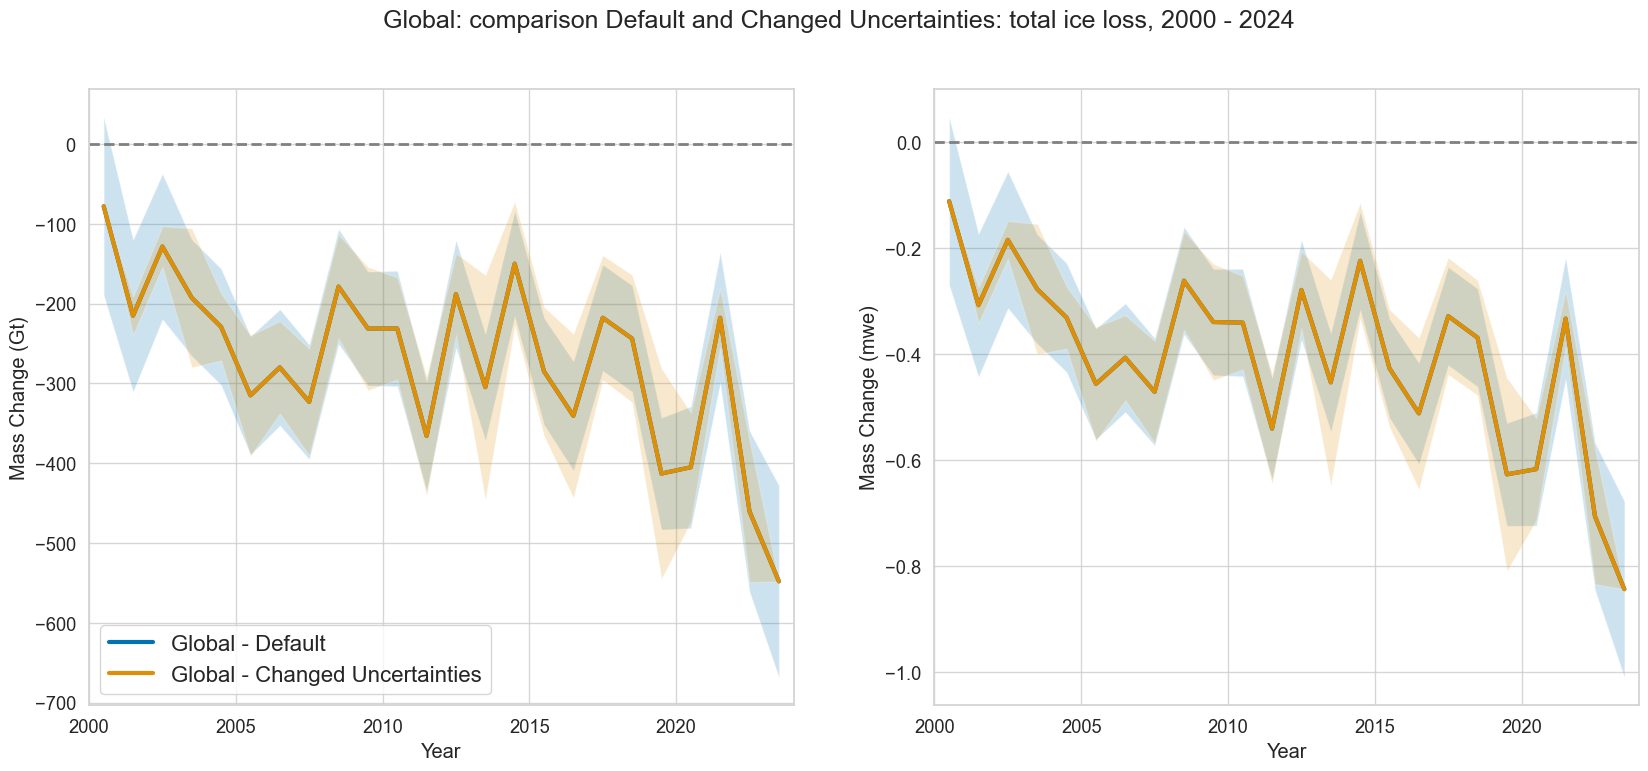

In [26]:
two_runs_comparison_plot(region_name='Global', data_distinction='Default', comparison_data_distinction='Changed Uncertainties', data_run_1=run1, data_run_2=run2)

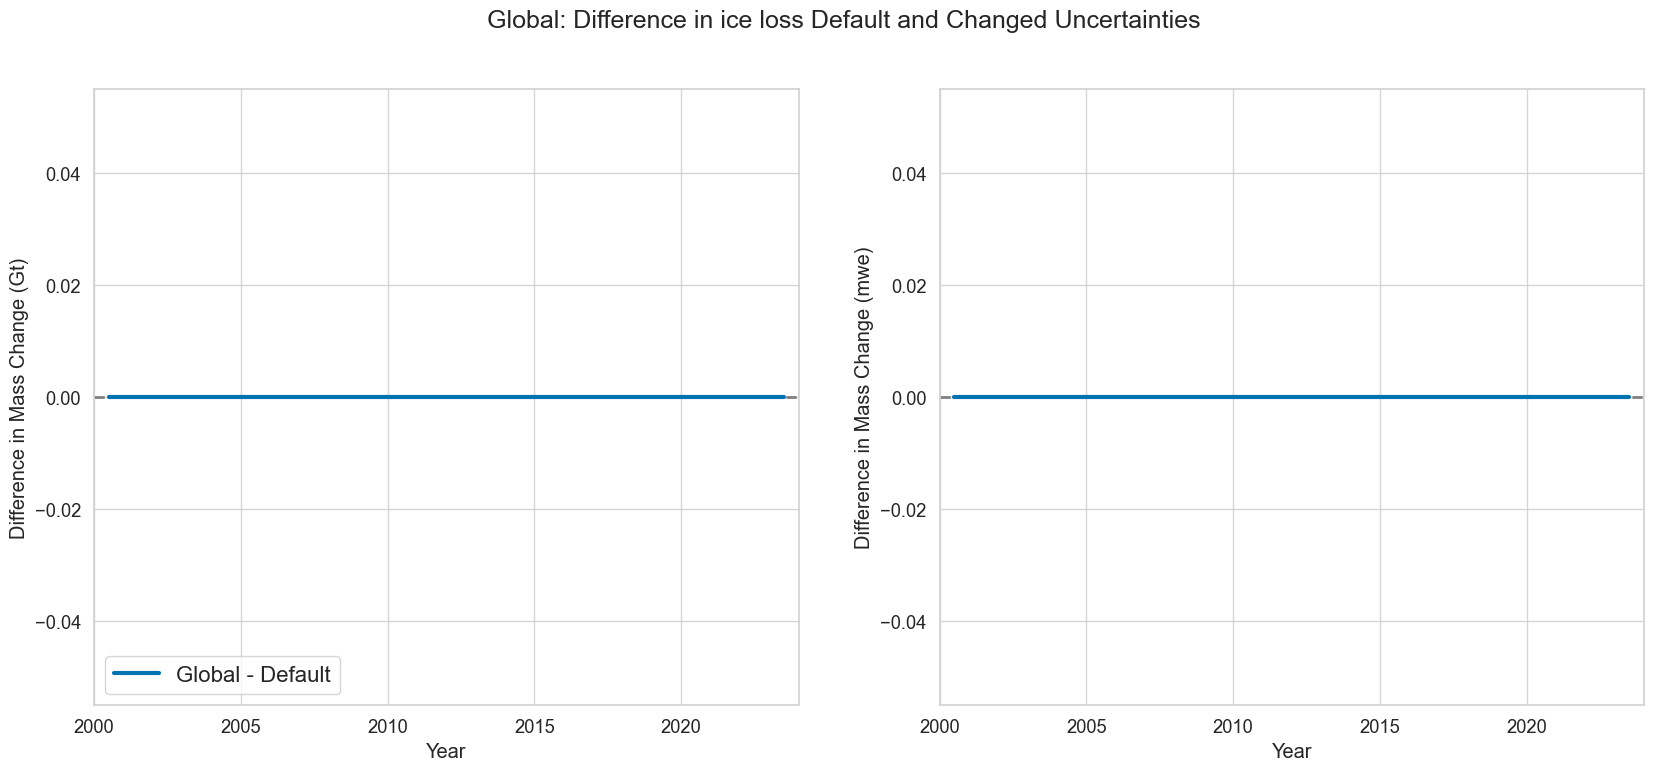

In [30]:
# Plot difference
two_runs_difference_plot(
    region_name='Global',
    data_distinction='Default',
    comparison_data_distinction='Changed Uncertainties',
    difference_data=merged_df
)

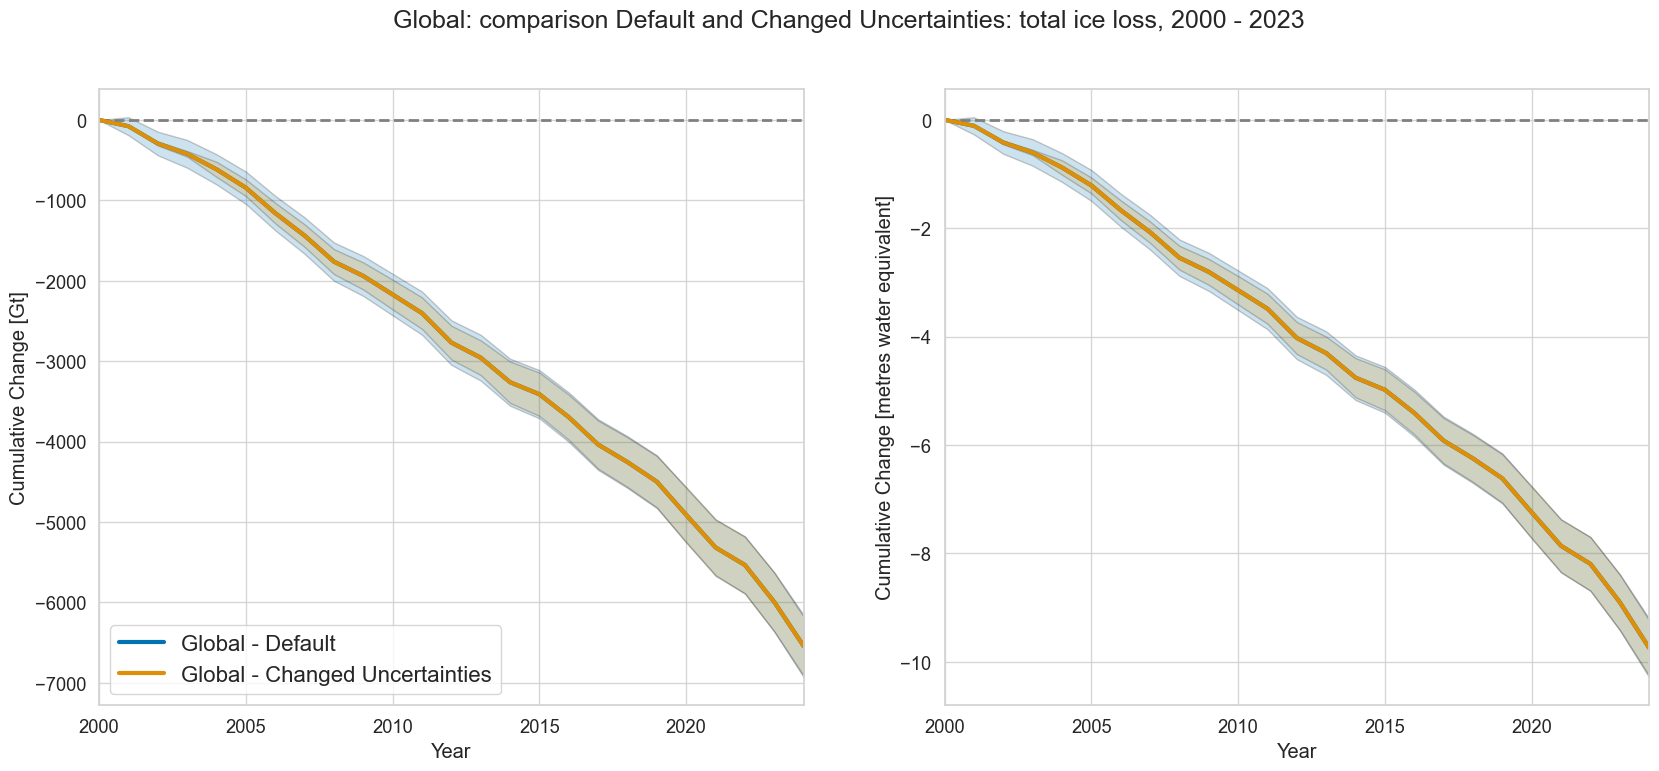

In [36]:
# Convert derivative data to cumulative format
cumulative_run1_gt = derivative_to_cumulative(
    start_dates=run1.start_dates,
    end_dates=run1.end_dates,
    changes=run1.combined_gt,
    calculate_as_errors=False
)
cumulative_errors_run1_gt = derivative_to_cumulative(
    start_dates=run1.start_dates,
    end_dates=run1.end_dates,
    changes=run1.combined_gt_errors,
    calculate_as_errors=True
)

cumulative_run2_gt = derivative_to_cumulative(
    start_dates=run2.start_dates,
    end_dates=run2.end_dates,
    changes=run2.combined_gt,
    calculate_as_errors=False
)
cumulative_errors_run2_gt = derivative_to_cumulative(
    start_dates=run2.start_dates,
    end_dates=run2.end_dates,
    changes=run2.combined_gt_errors,
    calculate_as_errors=True
)

cumulative_run1_mwe = derivative_to_cumulative(
    start_dates=run1.start_dates,
    end_dates=run1.end_dates,
    changes=run1.combined_mwe,
    calculate_as_errors=False
)
cumulative_errors_run1_mwe = derivative_to_cumulative(
    start_dates=run1.start_dates,
    end_dates=run1.end_dates,
    changes=run1.combined_mwe_errors,
    calculate_as_errors=True
)

cumulative_run2_mwe = derivative_to_cumulative(
    start_dates=run2.start_dates,
    end_dates=run2.end_dates,
    changes=run2.combined_mwe,
    calculate_as_errors=False
)
cumulative_errors_run2_mwe = derivative_to_cumulative(
    start_dates=run2.start_dates,
    end_dates=run2.end_dates,
    changes=run2.combined_mwe_errors,
    calculate_as_errors=True
)

# Plot cumulative comparison
two_runs_cumulative_comparison_plot(
    region_name='Global',
    data_distinction='Default',
    comparison_data_distinction='Changed Uncertainties',
    cumulative_data_all_gt=cumulative_run1_gt,
    cumulative_errors_all_gt=cumulative_errors_run1_gt,
    cumulative_data_all_gt_comparison=cumulative_run2_gt,
    cumulative_errors_all_gt_comparison=cumulative_errors_run2_gt,
    cumulative_data_all_mwe=cumulative_run1_mwe,
    cumulative_errors_all_mwe=cumulative_errors_run1_mwe,
    cumulative_data_all_mwe_comparison=cumulative_run2_mwe,
    cumulative_errors_all_mwe_comparison=cumulative_errors_run2_mwe
)
